In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Sklearn Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
print("Loading data...")
data = pd.read_csv("spam.csv", encoding="latin-1")#.fillna(0)
print("Data loaded.")

Loading data...
Data loaded.


Tablica ima viška stupaca bez imena i ikakve funkcije koje je potrebno maknuti, a osim toga bilo bi zgodnije nazvati prva dva stupca "label" i "message" da bolje opisuju podatke koji se u njima nalaze.

In [3]:
data.columns = ["label", "message", "1", "2", "3"]

In [4]:
data.head()

,label,message,1,2,3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data.drop(columns=["1", "2", "3"], inplace=True)
data["label"] = data["label"].apply(lambda x: 0 if x=="ham" else 1)

In [6]:
data.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Neki korisni pokazatelji mogli bi biti duljina poruka i broj riječi. 

Ono što se čini zgodno proučiti je možda omjer riječi i duljine poruke. Nazovimo to gustoćom riječi.

In [7]:
data["len"] = data["message"].apply(len)
data["words"] = data["message"].apply(lambda x: len(x.split(" ")))
data["word_density"] = data["words"]/data["len"]
#data["word_density"] = data["len"]/data["words"]

In [8]:
data.head()

,label,message,len,words,word_density
0,0,"Go until jurong point, crazy.. Available only ...",111,20,0.180180
1,0,Ok lar... Joking wif u oni...,29,6,0.206897
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,0.180645
3,0,U dun say so early hor... U c already then say...,49,11,0.224490
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,0.213115


In [9]:
ham_data = data[data["label"]==0]
spam_data = data[data["label"]==1]

Očigledno je da su spam poruke uglavnom puno duže od stvarnih poruka. To se čini logično. Svakodnevne SMS poruke su uvijek kratke i informativne dok su spam poruke možda promišljenije jer ipak pokušavaju pridobiti pažnju primatelja poruke. Definitivno neće izgledati kao svakodnevna poruka koju možda šaljemo bez razmišljanja.

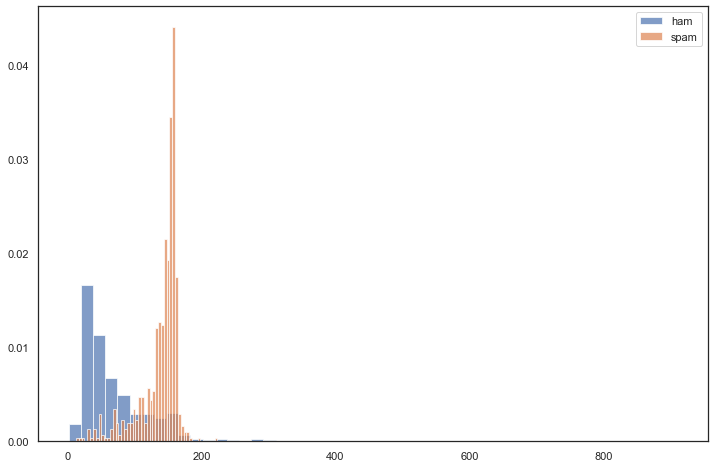

In [10]:
plt.figure(figsize=(12,8))
plt.hist(ham_data["len"], bins=50, density=1, label="ham", alpha = 0.7);
plt.hist(spam_data["len"], bins=50, density=1, label="spam", alpha = 0.7);
plt.legend()

Isto tako spam poruke imaju uglavnom više riječi od normalnih poruka.

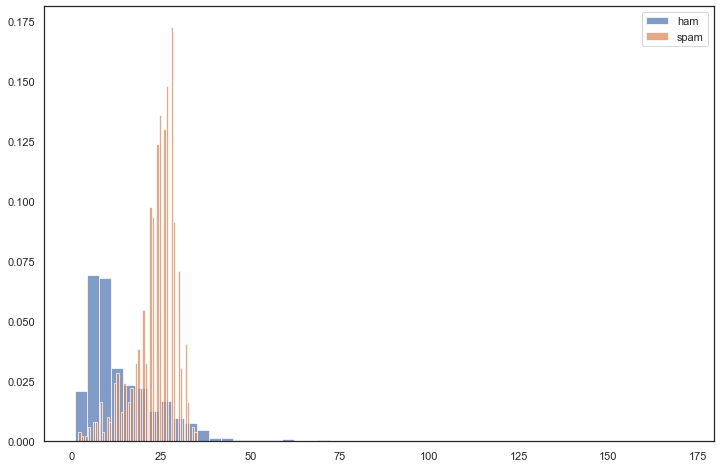

In [11]:
plt.figure(figsize=(12,8))
plt.hist(ham_data["words"], bins=50, density=1, label="ham", alpha = 0.7);
plt.hist(spam_data["words"], bins=50, density=1, label="spam", alpha = 0.7);
plt.legend()

Gustoća riječi u rečenici je samo kompaktniji način za opisati veličinu poruka. Ono što je vidljivo je da spam poruke imaju uglavnom manju gustoću riječi. To znači da imaju manje riječi za istu duljinu poruke. To ide u korist ideji da su spam poruke promišljenije i efikasnije. Možda su poruke duže, ali su riječi pomnije odabrane.

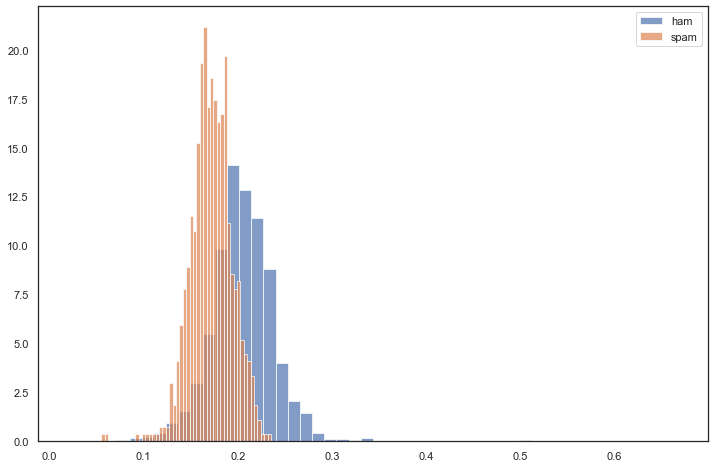

In [12]:
plt.figure(figsize=(12,8))
plt.hist(ham_data["word_density"], bins=50, density=1, label="ham", alpha = 0.7);
plt.hist(spam_data["word_density"], bins=50, density=1, label = "spam", alpha = 0.7);
plt.legend()

Pokušajmo s ta tri stupca tablice predvidjeti spam poruke s nekoliko modela.

In [13]:
#funkcija za testiranje modela
def test_model(estimator, X_train_, X_test_, y_train_, y_test_):
    estimator.fit(X_train_, y_train_)
    prediction=estimator.predict(X_test_)
    print()
    print(type(estimator).__name__)
    print()
    #ispis svih vrijednosti
    print(classification_report(y_test,prediction))
    #crtanje
    fig = plt.figure(figsize=(22,7), num=type(estimator).__name__)
    ax = fig.add_subplot(1,3,1)
    sns.heatmap(confusion_matrix(y_test_,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    ax = fig.add_subplot(1,3,2)
    metrics.plot_roc_curve(estimator, X_test_, y_test_, ax=ax)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = fig.add_subplot(1,3,3)
    metrics.plot_precision_recall_curve(estimator, X_test_, y_test_, ax=ax)
    f1=metrics.f1_score(y_test_, prediction)
    print("F1:", f1)

In [14]:
#modeli
logreg = LogisticRegression()
kneighbors = KNeighborsClassifier()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
nb = MultinomialNB()
models = [logreg, kneighbors, tree, forest, nb]

In [15]:
X = data.drop(["label", "message"], axis=1)
y = data["label"].ravel()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


LogisticRegression

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1587
           1       0.65      0.45      0.53       252

    accuracy                           0.89      1839
   macro avg       0.78      0.71      0.74      1839
weighted avg       0.88      0.89      0.88      1839

F1: 0.5317647058823529

KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1587
           1       0.67      0.62      0.65       252

    accuracy                           0.91      1839
   macro avg       0.81      0.79      0.80      1839
weighted avg       0.90      0.91      0.91      1839

F1: 0.647422680412371

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1587
           1       0.72      0.57      0.64       252

    accuracy                           0.91      1839
   macro avg  

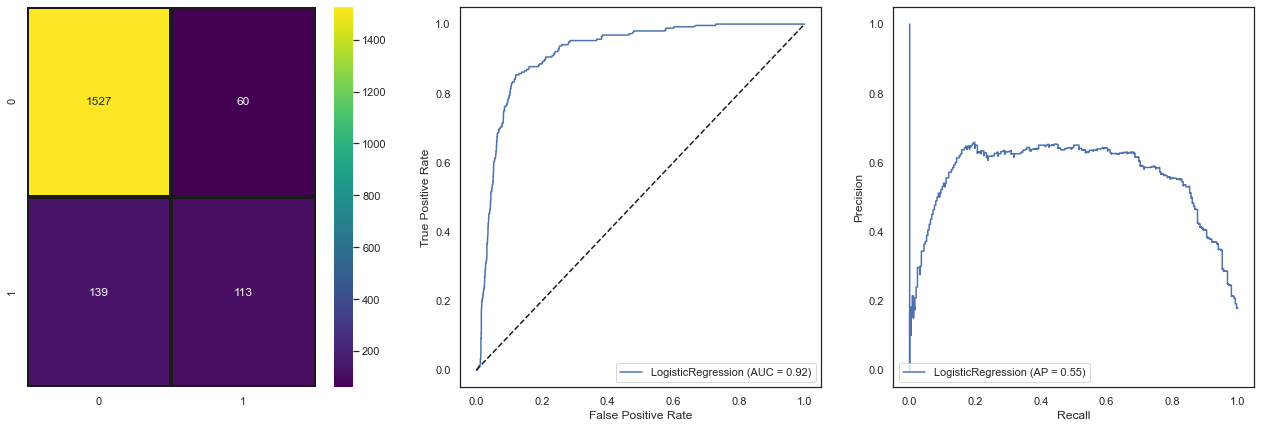

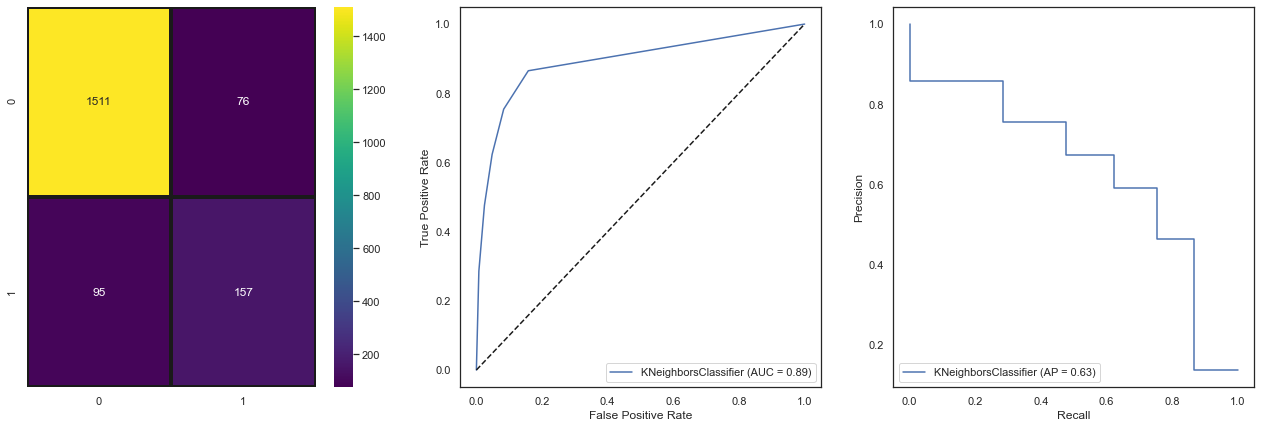

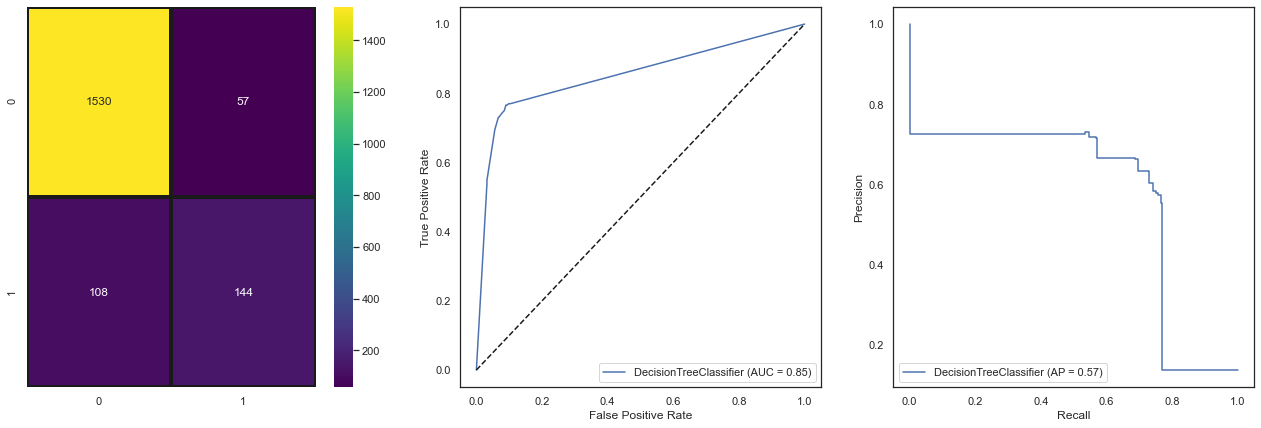

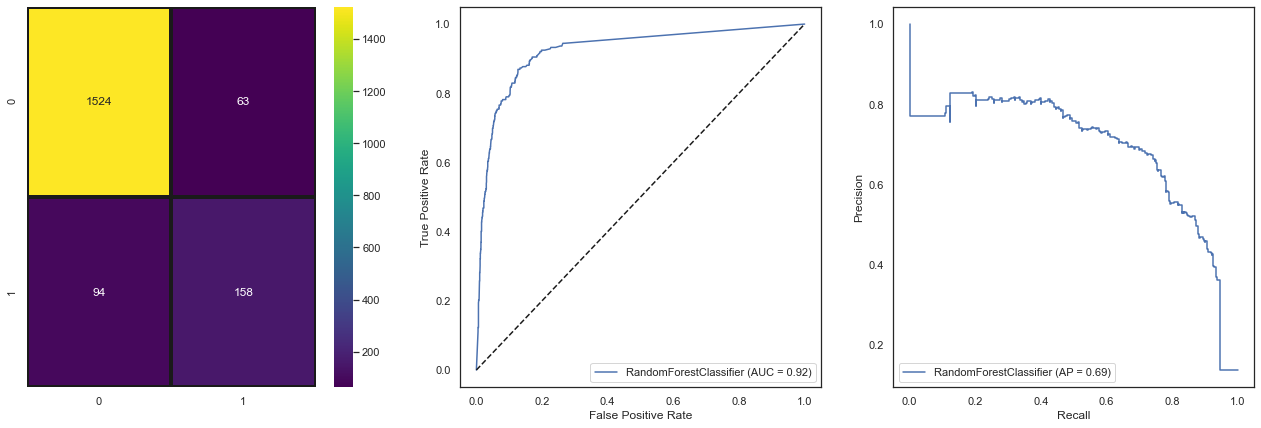

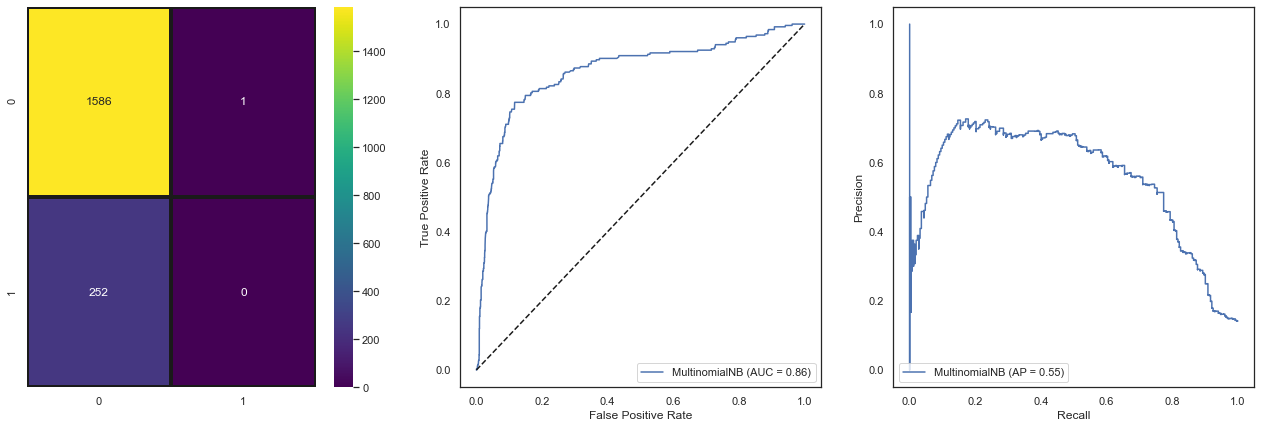

In [17]:
for m in models:
    test_model(m, X_train, X_test, y_train, y_test)

S obzirom na vrlo jednostavnu analizu rezultati su bolji nego očekivani. Duljina poruke i broj riječi su skroz OK prediktori. No svejedno samo su OK, ništa više. Većina modela krivo je svrstala trećinu spam poruka i na to još dodala stotinjak pravih poruka u spam. Za bolje rezultate potrebno je analizirati svaku riječ u rečenici.

Da bi se moglo analizirati riječi potrebno ih je nekako pretvoriti u numeričke vrijednosti jer modeli koje koristimo zahtjevaju numeričke vrijednosti. Jedan način je korištenje **The bag of words** metode koja reprezentira text u matricu koja sadrži informacije o broju ponavljanja riječi unutar cijelog nekog dokumenta. Naš dokument biti će cijeli stupac poruka. Prije toga poželjno je maknuti barem znakove u porukama i u svim riječima smanjiti slova.

In [18]:
tokenizer = nltk.RegexpTokenizer(r"\w+") #bez znakova
data["tokenized_message"] = [" ".join(tokenizer.tokenize(x.lower())) for x in data["message"]]

In [19]:
data.head()

,label,message,len,words,word_density,tokenized_message
0,0,"Go until jurong point, crazy.. Available only ...",111,20,0.180180,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,6,0.206897,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,0.180645,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,49,11,0.224490,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,0.213115,nah i don t think he goes to usf he lives arou...


In [20]:
X = data["tokenized_message"]#.drop(["label", "message"], axis=1)
y = data["label"].ravel()

In [21]:
#The bag of words, broji pojave riječi kroz cijeli dataset i sparse matricu s brojem ponavljanja tih riječi
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
# from sklearn.feature_extraction.text import TfidfTransformer

# tfidf_transformer = TfidfTransformer()
# tfidf_transformer.fit(X_train)
# tfidf_transformer.transform(X_train)

# tfidf_transformer.fit(X_test)
# tfidf_transformer.transform(X_test)


LogisticRegression

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1587
           1       0.99      0.86      0.92       252

    accuracy                           0.98      1839
   macro avg       0.98      0.93      0.95      1839
weighted avg       0.98      0.98      0.98      1839

F1: 0.9171974522292993

KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1587
           1       1.00      0.37      0.54       252

    accuracy                           0.91      1839
   macro avg       0.95      0.69      0.75      1839
weighted avg       0.92      0.91      0.90      1839

F1: 0.5433526011560694

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1587
           1       0.85      0.86      0.86       252

    accuracy                           0.96      1839
   macro avg 

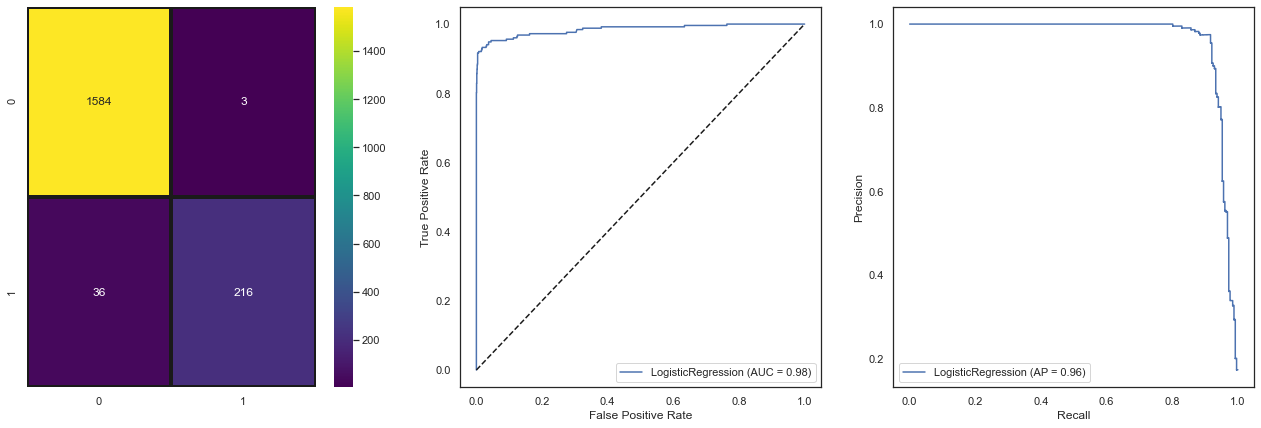

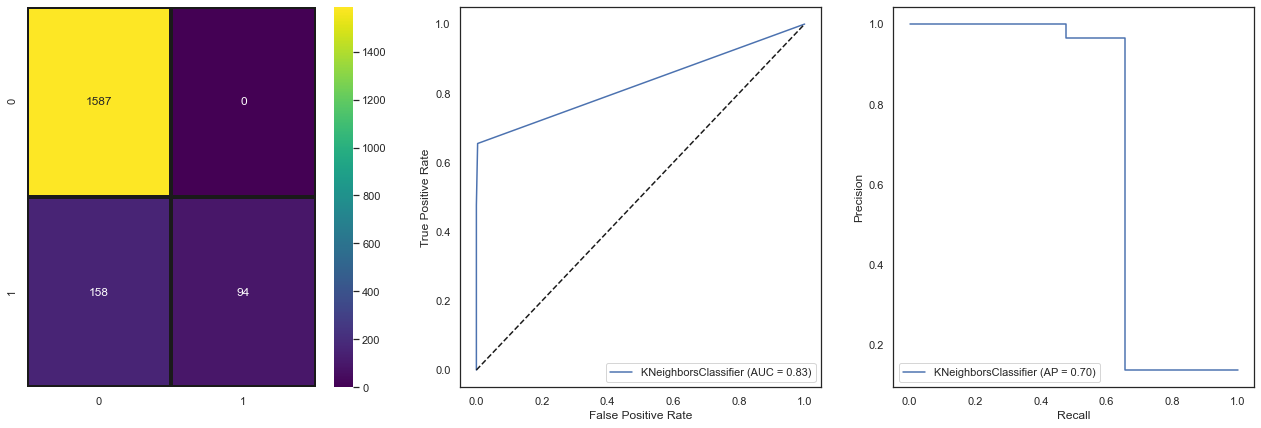

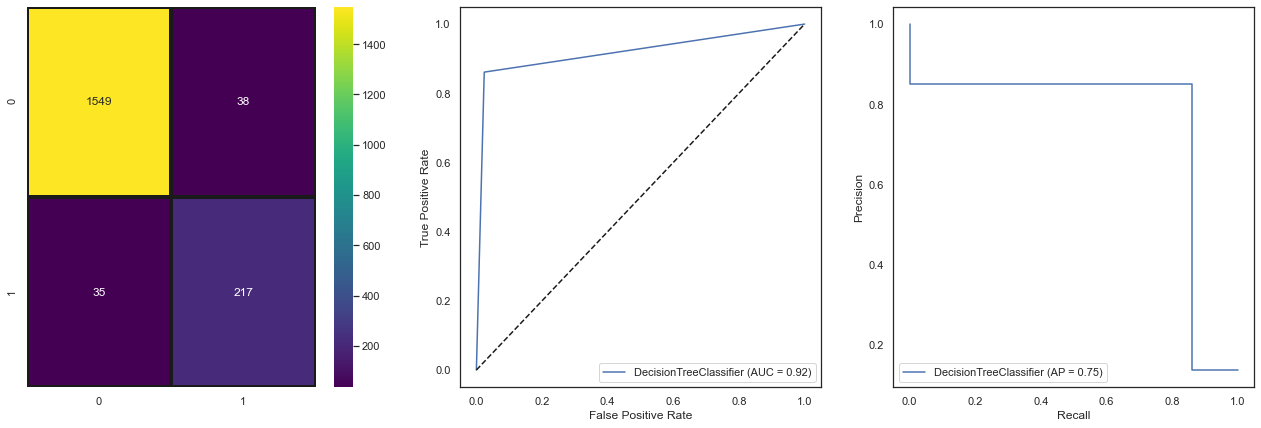

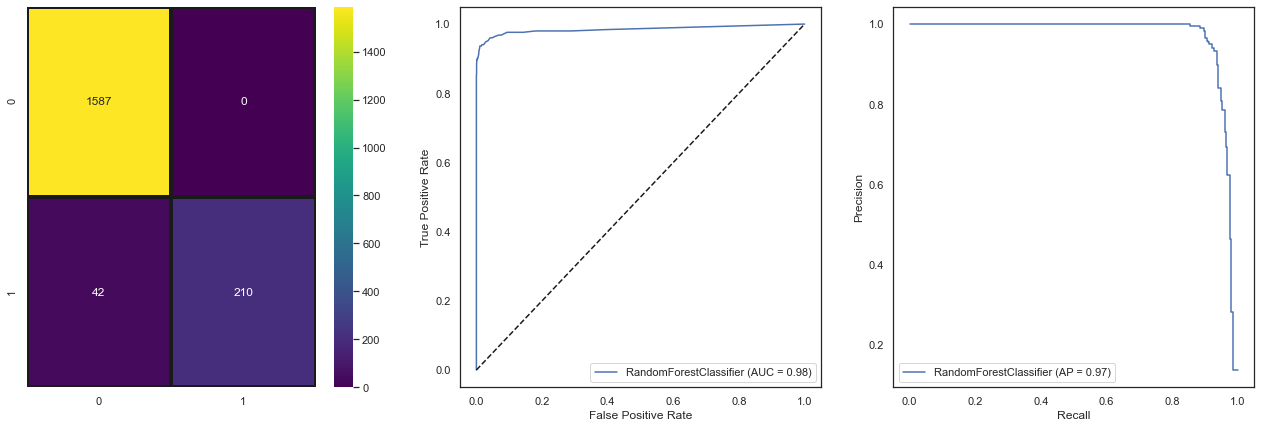

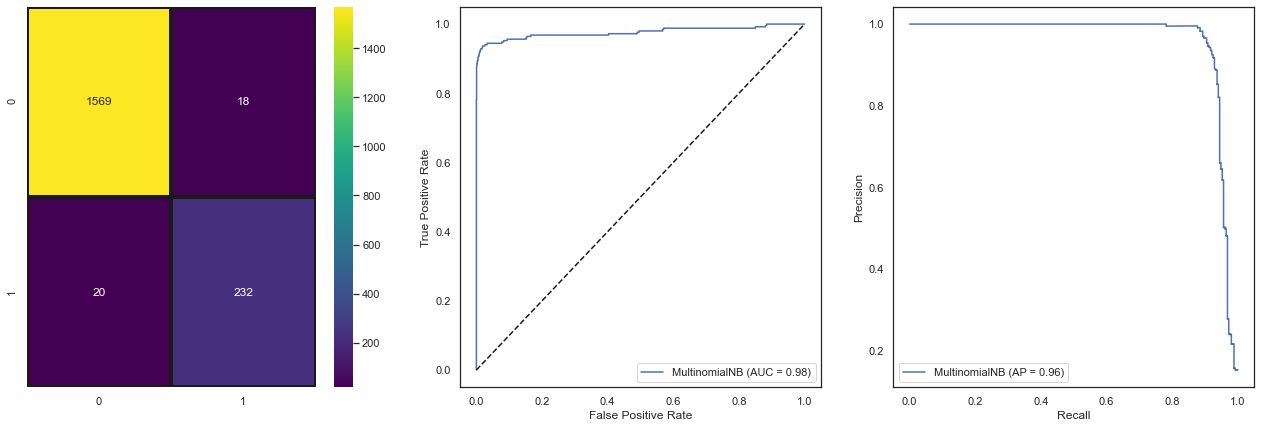

In [24]:
for m in models:
    test_model(m, X_train, X_test, y_train, y_test)

Kod nekih algoritama se odmah vide izvrsni rezultati! Najviše potencijala pokazuju Naive Bayes, Random Forest i Logistic Regression. Imaju visok recall, odnosno vrlo dobro prepoznaju spam poruke, a nije tako strašno završiti s dvadesetak krivo svrstanih ham poruka. No naravno to nije dovoljno dobro. 

Za bolje rezultate potrebno je izvršiti provjeru parametara pomoću GridSearchCV i boljom obradom podataka.
Iz teksta je moguće izbaciti takozvane stopwords koje ne doprinose razgovoru i mogu se naći u bilo kojem tipu poruke bez da pružaju dodatnu informaciju o tipu poruke.

Isto tako bilo bi dobro normalizirati i odrediti težinske faktore riječi koristeći TF-IDF mjeru kako bi se smanjio utjecaj riječi koje se pojavljuju u većini redaka tablice.